/Users/chenpeiwen/opt/anaconda3/envs/tf20/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


param  _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')


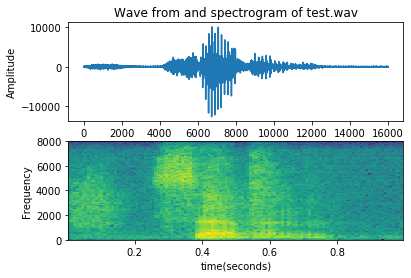

In [47]:
##记录一下 shift+tab 查看wav api. 源码api说明路径~/opt/anaconda3/envs/tf20/lib/python3.7/wav.py
##公式参考 http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
import wave
import numpy as np
import matplotlib.pyplot as plt

fw = wave.open('data/seven/fffcabd1_nohash_1.wav','r')
soundInfo = fw.readframes(-1)
#print(soundInfo.dtype)
#print(soundInfo)
soundInfo = np.fromstring(soundInfo,np.int16)
#soundInfo2 = soundInfo.tostring()
#print(soundInfo2)
f = fw.getframerate()
param = fw.getparams()
print('param ' ,param)
fw.close()

plt.subplot(211)
plt.plot(soundInfo)
plt.ylabel('Amplitude')
plt.title('Wave from and spectrogram of test.wav')

plt.subplot(212)
plt.specgram(soundInfo,Fs = f, scale_by_freq = True, sides = 'default')
plt.ylabel('Frequency')
plt.xlabel('time(seconds)')
plt.show()

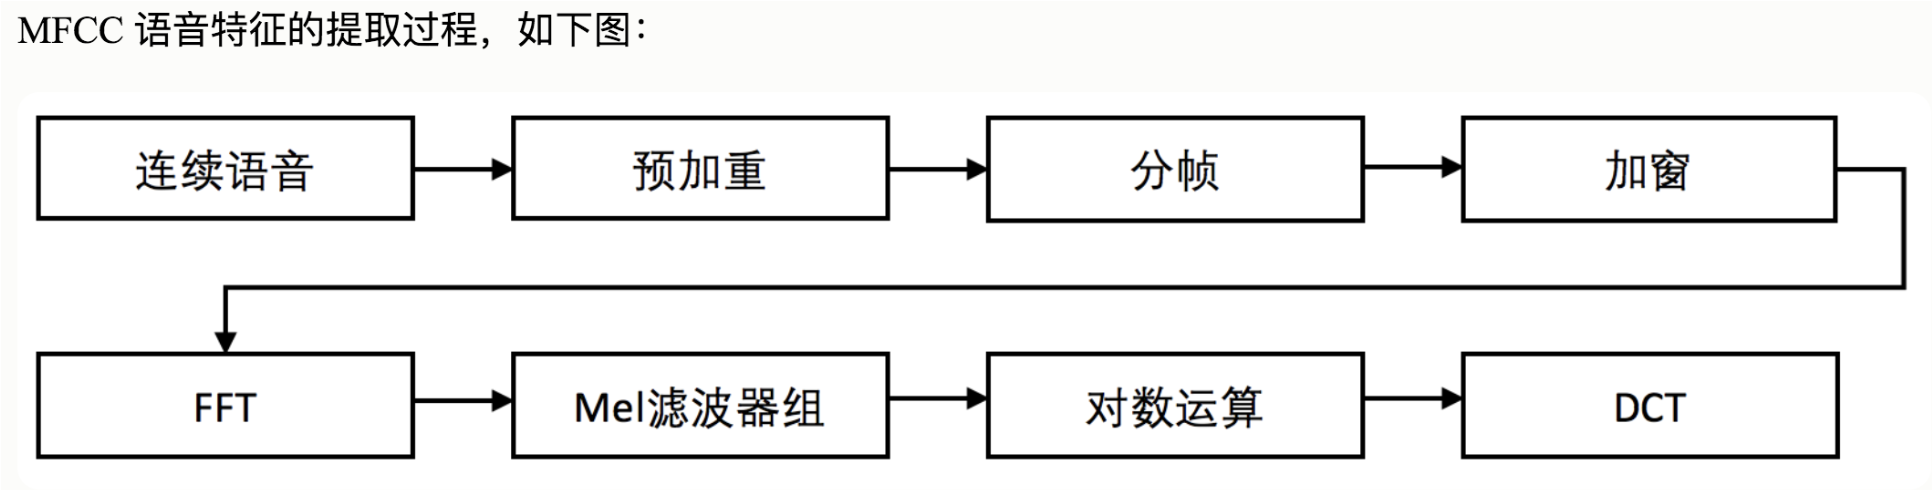

$$H(z)=1-uz^{-1}$$
$$y(t)=x(t)−αx(t−1)$$

[ -1.   -24.03  -6.75 ... -46.87  30.75  13.74]


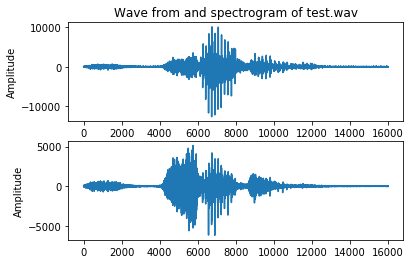

In [58]:
#预加重
def pre_emphasis(signal, coefficient=0.97):
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])
emphasized_signal2 = pre_emphasis(soundInfo)

plt.subplot(211)
plt.plot(soundInfo)
plt.ylabel('Amplitude')
plt.title('Wave from and spectrogram of test.wav')
plt.subplot(212)
plt.plot(emphasized_signal2)
plt.ylabel('Amplitude')
#plt.title('Wave from and spectrogram of test.wav to emphasized_signal2')

print (emphasized_signal2)



In [56]:
#我的目标是把预加重处理之后的数据再创建一个新的wav
fw = wave.open('fffcabd1_nohash_1_yjc.wav','w')
fw.setparams(param)
fw.writeframes(emphasized_signal2.astype(np.short).tostring());


frame_length 400
signal_length 16000
frame_step 160
num_frames 98
pad_signal_length 16080
indices [[    0     1     2 ...   397   398   399]
 [  160   161   162 ...   557   558   559]
 [  320   321   322 ...   717   718   719]
 ...
 [15200 15201 15202 ... 15597 15598 15599]
 [15360 15361 15362 ... 15757 15758 15759]
 [15520 15521 15522 ... 15917 15918 15919]]
frames (98, 400)


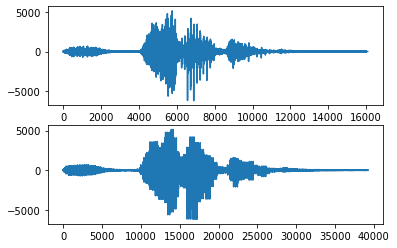

In [194]:
#分帧 这一步背后的基本原理是信号中的频率随时间而变化，所以在大多数情况下，对整个信号进行傅立叶变换是没有意义的，因为我们会随着时间的推移丢失信号的频率轮廓。为了避免这种情况，我们可以安全地假设信号中的频率在很短的时间内是平稳的。因此，通过在这个短时间帧内进行傅里叶变换，我们可以通过连接相邻帧来获得信号的频率轮廓的良好近似。
emphasized_signal = emphasized_signal2
sample_rate = 16000
frame_size=0.025
frame_stride=0.01
frame_length,frame_step=frame_size*sample_rate,frame_stride*sample_rate
signal_length=len(emphasized_signal)
frame_length=int(round(frame_length))
frame_step=int(round(frame_step))
num_frames=int(numpy.ceil(float(numpy.abs(signal_length-frame_length))/frame_step))
print('frame_length',frame_length)
print('signal_length',signal_length)
print('frame_step',frame_step)
print('num_frames',num_frames)

pad_signal_length=num_frames*frame_step+frame_length
print('pad_signal_length',pad_signal_length)
z=numpy.zeros((pad_signal_length-signal_length))
pad_signal=numpy.append(emphasized_signal,z)

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

print('indices',indices)

frames = pad_signal[numpy.mat(indices).astype(numpy.int32, copy=False)]

print('frames',frames.shape)
#frames_up = frames *5000  #对声音进行放大  OMG!!!
frames_up = frames

plt.subplot(211)
plt.plot(pad_signal)
plt.subplot(212)
plt.plot(frames_up.flatten())
plt.show()

#好吧 分帧之后的声音有点像机器人
fw = wave.open('fffcabd1_nohash_1_fenzhen.wav','w')
fw.setparams(param)
fw.writeframes(frames_up.flatten().astype(np.short).tostring());


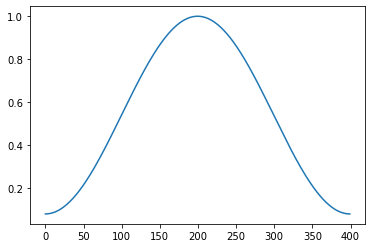

(400,)


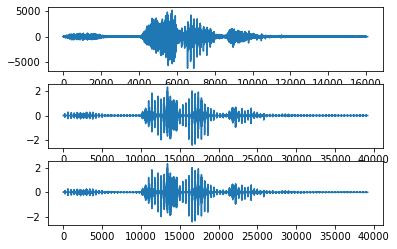

In [216]:
#window plus
hanming = numpy.hamming(frame_length)
#hanming = 0.54 - 0.46 * numpy.cos((2 * numpy.pi * 12) / (frame_length - 1))
plt.plot(hanming)
plt.show()
print(hanming.shape)
frames *= hanming # Explicit Implementation **123
plt.subplot(311)
plt.plot(pad_signal)
plt.subplot(312)
plt.plot(frames_up.flatten())
plt.subplot(313)
plt.plot(frames.flatten())
plt.show()

#好吧 加窗后出现抖动 感觉像对着电风扇说话的声音
fw = wave.open('fffcabd1_nohash_1_hanming.wav','w')
fw.setparams(param)
fw.writeframes(frames.flatten().astype(np.short).tostring());

(98, 257)


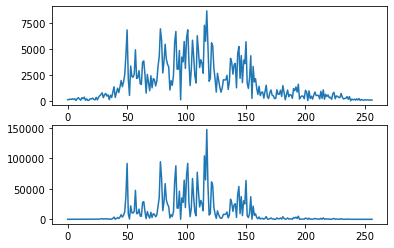

In [164]:
#傅立叶变换和功率谱
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
print(mag_frames.shape)
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
#plt.subplot(311)
#plt.plot(frames[0])
plt.subplot(211)
plt.plot(mag_frames[0])
plt.subplot(212)
plt.plot(pow_frames[0])
plt.show()

2840.023046708319


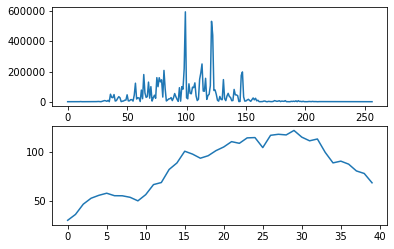

[-128.43696187  -83.096662     42.75020052   -5.67148252   14.79779425
  -12.89394702  -11.03979274   -3.7218308    -0.77164724   -8.63633956
   -5.8680237     6.37395139]


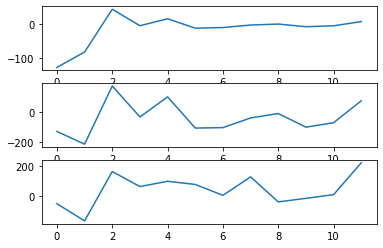

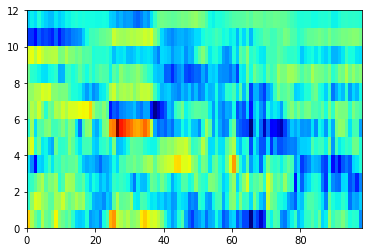

In [192]:
##将频率转换为Mel
low_freq_mel = 0
nfilt = 40 
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))
print(high_freq_mel)
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
#plt.plot(hz_points)
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)
fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

#print(pow_frames[0])
plt.subplot(211)
plt.plot(pow_frames[2])
plt.subplot(212)
#print(filter_banks[0])
plt.plot(filter_banks[2])
plt.show()

num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
(nframes, ncoeff) = mfcc.shape
print(mfcc[0])
plt.subplot(311)
plt.plot(mfcc[0])

n = numpy.arange(ncoeff)
cep_lifter =22
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*
plt.subplot(312)
plt.plot(mfcc[0])

#filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
plt.subplot(313)
plt.plot(mfcc[0])

plt.show()

mfcc_data = mfcc.T
#plt.imshow(mfcc_data, cmap=plt.cm.jet, extent=[0, mfcc_data.shape[1], 0, mfcc_data.shape[0]], aspect='auto')
plt.imshow(mfcc_data, cmap=plt.cm.jet, extent=[0, mfcc_data.shape[1], 0, mfcc_data.shape[0]], aspect='auto')
plt.show()


In [113]:
#mfcc
from scipy.io import wavfile as wav
from python_speech_features import *
(rate,sig)  = wav.read('data/seven/fffcabd1_nohash_1.wav')
#print(sig)
wav_feature = mfcc(sig,rate)
d_mfcc_feat = delta(wav_feature, 1)
#print(d_mfcc_feat)
d_mfcc_feat2 = delta(wav_feature, 2)
feature = np.hstack((wav_feature, d_mfcc_feat, d_mfcc_feat2))
print (wav_feature.shape)

[[ 0.3509349   2.99290104  0.08681617 ...  1.12688929  3.93297127
  -3.1120754 ]
 [ 0.48529473  1.27889127 -2.9340856  ...  1.30288853  7.42730578
  -5.12454908]
 [ 0.24829511  2.33102368  2.26053718 ...  2.65955439  3.18226649
  -3.38019415]
 ...
 [ 0.06227079 -0.74521694 -1.25236985 ...  3.56570488  4.61584867
  -1.48238131]
 [-0.06213085 -0.99824761 -1.9085363  ...  1.40539859  3.0990764
  -1.84463846]
 [-0.08228968 -0.47490239 -1.16670435 ... -3.08469155 -0.77715988
  -0.37262142]]
(99, 13)


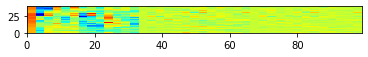

In [154]:
mfcc_data = feature
#plt.imshow(mfcc_data, cmap=plt.cm.jet, extent=[0, mfcc_data.shape[1], 0, mfcc_data.shape[0]], aspect='auto')
#plt.show()
plt.imshow(mfcc_data, cmap=plt.cm.jet, aspect=0.2, extent=[0,mfcc_data.shape[0],0,mfcc_data.shape[1]])#热力图
plt.show()

In [217]:
# for i in range(0,13):
#     print (i)
#     plt.subplot(13,1,i+1)
#     plt.plot(mfcc_data.T[i])
#     plt.show()
# mfcc 的逆运算  ifft
# s = np.fft.ifft(mfcc_data.T)
# print (s.shape)
# for i in range(0,13):
#     print (i)
#     plt.subplot(13,1,i+1)
#     plt.plot(s[i])
#     plt.show()